In [647]:
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt
import pickle, gzip, urllib.request, json

In [648]:
#To ensure reproducibility
random.seed(11)
np.random.seed(11)

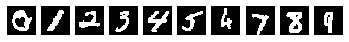

In [649]:
# Load the dataset
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

# Get the data into arrays
images = train_set[0]
labels = train_set[1]

# Put aside an array for the patterns
patterns = np.zeros((10,784))
    
# Set aside one image per class to store (10 images in total)
for category in range(10):
    inclass = [i for i in range(labels.shape[0]) if labels[i] == category]
    # thresholded to -1s and 1s; changes all 0s to -1s in the array.
    patterns[category,:] = 1.0*(images[inclass[random.randint(0,len(inclass))],:] > 0)
    patterns[category,:][patterns[category,:] == 0] = -1

#Plot the patterns we're going to store
fig, axs = plt.subplots(1,10)
for c in range(10):
    axs[c].imshow(patterns[c,:].reshape((28,28)), cmap='gray')
    axs[c].axis("off")
plt.show()

------
## Rational behind update and store one
So I won't forget when looking at this later

### .update()
Given that W is the weight matrix, and V is the state vector of the network:

$net_{i}(t) = \sum_{j \neq i} w_{ij} \cdot V_j = W[i,:] \cdot V$

Which results in the following:

$V_i = +1 \textit{ if } net_{i}(t) > \theta_i$

$V_i = -1 \textit{ if } net_{i}(t) < \theta_i$

### .store_one()
In the lecture slides, was given that:

$\Delta W_{ij} = \eta o_{i}(t)o_{j}(t)$

$\Delta \theta_{i} = -\eta o_{i}(t)$

In [650]:
class hopfield_network(object):   
    # The initialization function for the hopfield network
    def __init__(self,N):
        """
        Initialize with following params and internal variables:
        
        ::PARAM1:: N is the number of units
        ::self.state:: is the current state of the network
        ::self.W:: is the weight matrix
        """
        self.state = np.zeros((N,)) # 784x1
        self.W = np.zeros((784, 784)) # 784x784
        self.theta = np.zeros((N,)) # 784x1
    
    # The function for setting the activity state of the network
    def set_state(self,activity):
        """
        Sets the state of the network to the pattern given by activity.
        
        ::PARAM1:: activity - the activity (a 784-array) to set the network state as
        """
        # set the state to activity
        # need a shallow copy so it doesnt mess things up
        self.state = activity.copy()
        
    # The function for updating the state of the network
    def update(self, i):
        """
        hopfield updates one of its units.
        
        ::PARAM1:: i = target index of the state vector
        ::OUTPUT:: self.state - the state of the network afterwards
        """
        # i = random.randint(0,783) # maybe randomly modify instead of iteratively?
        # summation(j) of w_ij*State_j == dot product of W[i,:] and State vector 
        net_input = np.dot(self.W[i,:], self.state)

        # if >= threshold, update unit to be 1. Else -1.
        if net_input >= self.theta[i]:
            self.state[i] = 1
        else:
            self.state[i] = -1
        
        # return the updated state
        return self.state
    
    # The function for storing one image at a time (one pattern at the time using gradient descent)
    def store_one(self,image,eta=1):
        """
        The function for storing one image at a time, using the delta definitions
        given in the lecture slides. Stores the changes of the weight matrix by a
        new state (image) and changes theta for each index of the state vector.
        
        Design choice note for myself: does += so that I can call this multiple
        times and just add more patterns instead of hard setting the weights.
        
        ::PARAM1:: image - an 784 array (28x28 pixel image) a new memory to store
        ::PARAM2:: eta - learning rate (default = 1)
        """
        # go through all W_ij combinations using 2 for loops of i and j index
        for i in range(784):
            # delta of threshold
            self.theta[i] -= eta*image[i]
            for j in range(i, 784):
                if i == j:
                    pass
                else:
                    delta_w = eta*image[i]*image[j]
                    # delta of weight at (ij) and (ji) are equal due to W matrix symmetry
                    self.W[i][j] += delta_w
                    self.W[j][i] += delta_w
                
    # The function for storing multiple images in one shot (the big product of all patterns to store)
    def store_multi(self,images,eta=1):
        """
        stores the changes of the weight matrix by a series of new states and changes the theta
        threshold for each index of the state vector.
        
        Design choice note for myself: does += so that I can call this multiple
        times and just add more patterns instead of hard setting the weights.
        
        ::PARAM1:: images - set of images (image =an 784 array (28x28 pixel image))
        ::PARAM2:: eta - the learning rate (default = 1)
        """
        # summation over each new state (image of a number)
        for image in images:
            # now for iteration of \delta(W_ij) from the image.
            for i in range(784):
                # delta of threshold
                self.theta[i] -= eta*image[i]
                for j in range(i, 784):
                    if i == j:
                        pass
                    else:
                        delta_w = eta*image[i]*image[j]
                        # delta of weight at (ij) and (ji) are equal due to W matrix symmetry
                        self.W[i][j] += delta_w
                        self.W[j][i] += delta_w
                        
                        
    # ****** DEBUGGING FUNCTION ******                
    # my own testing function; prints energy value as dot prod of = V.T W V
    def energy(self):
        temp = np.dot(self.W, np.array([self.state]).T)
        energy = -1*np.dot(np.array([self.state]), temp)
        print(energy)

In [651]:
# Some helper functions for generating test images

# The function for generating a noisy version of an image
def image_noise(image,noise_level=0.1):
    """     
    This function takes an image, adds noise to it, and returns it. 
    noise_level - between 0-1, try experimenting with this
    """
    # create a mask for adding noise to the image
    image[image == -1] = 0
    image_mask = random.uniform(size=image.shape) < noise_level
    # original return array
    image_n = 1.0*np.logical_xor(image,image_mask)
    # convert back to -1 and 1s
    image_n[image_n == 0] = -1
    image[image == 0] = -1
    return image_n
    
# The function for generating a combo of two images
def image_combo(image1,image2,image1_weight=0.5):
    """
    This function takes a pair of images, combines them, and returns the result.
    image1_weight - between 0-1, try experimenting with this.
    I dont see really anything broken with this helper function, so keeping it as it was given
    """
    # create a mask for mixing the images
    image1_mask = random.uniform(size=image1.shape) < image1_weight
    return image1_mask*image1 + (1-image1_mask)*image2

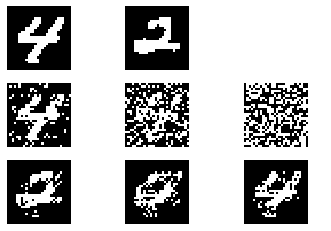

In [652]:
# Test the helper functions to make sure they work

# Pick some random images
image1 = patterns[random.randint(0,10)]
image2 = patterns[random.randint(0,10)]

# Create a little array for storage
test_images = np.zeros((2,3,784)) # 28-28 pixel images

# Generate a series of noise images
test_images[0,0,:] = image_noise(image1)
test_images[0,1,:] = image_noise(image1,noise_level=0.3)
test_images[0,2,:] = image_noise(image1,noise_level=0.5)

# Generate a series of combo images
test_images[1,0,:] = image_combo(image1,image2,image1_weight=0.2)
test_images[1,1,:] = image_combo(image1,image2)
test_images[1,2,:] = image_combo(image1,image2,image1_weight=0.8)

# Plot the images, plus the originals on top
fig, axs = plt.subplots(3,3)
axs[0,0].imshow(image1.reshape((28,28)), cmap='gray')
axs[0,0].axis("off")
axs[0,1].imshow(image2.reshape((28,28)), cmap='gray')
axs[0,1].axis("off")
axs[0,2].axis("off")
for c in range(3):
    axs[1,c].imshow(test_images[0,c,:].reshape((28,28)), cmap='gray')
    axs[1,c].axis("off")
    axs[2,c].imshow(test_images[1,c,:].reshape((28,28)), cmap='gray')
    axs[2,c].axis("off")
plt.show()

In [653]:
# Create a Hopfield network and train it

one_pattern = True # flag for whether to store one pattern at a time
eta = 1 # learning rate

hnet = hopfield_network(784) # construct the network

if one_pattern:
    # Train the network to store all the patterns using your store_one function
    for i in range(10):
        hnet.store_one(patterns[i], eta)
else:
    # Train the network to store all the patterns using your store_multi function 
    hnet.store_multi(patterns, eta)

# DEBUG: seeing if squishing weights changes things.
# hnet.W = np.divide(hnet.W, 784) # 100? 784?

# Running Hopfield Network 
Moving from a noisey image to a pattern

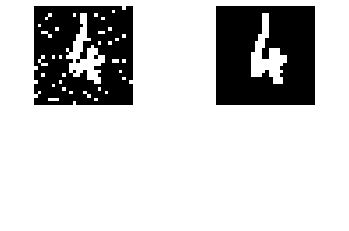

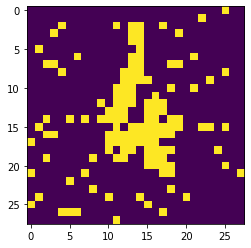

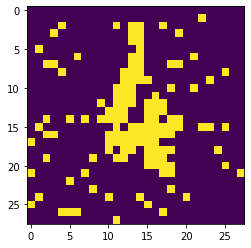

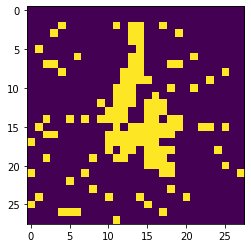

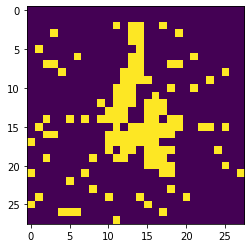

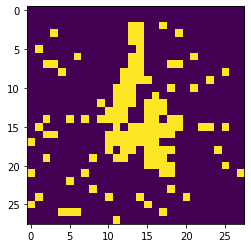

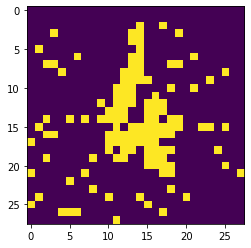

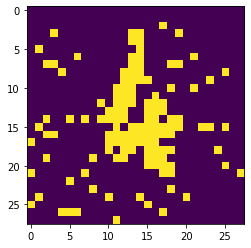

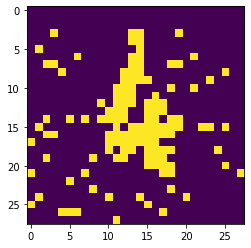

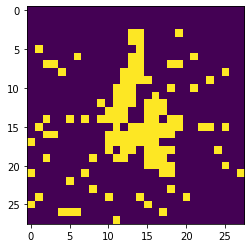

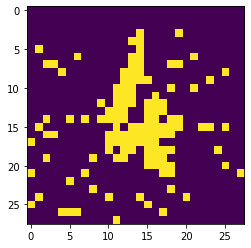

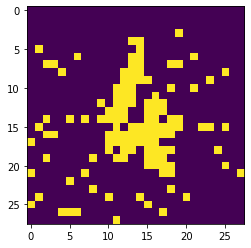

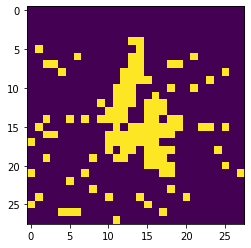

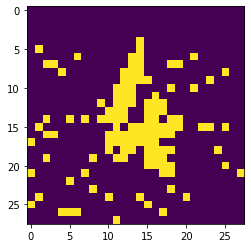

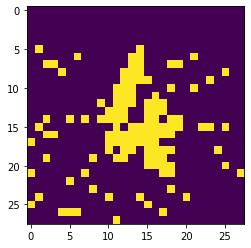

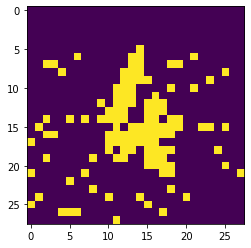

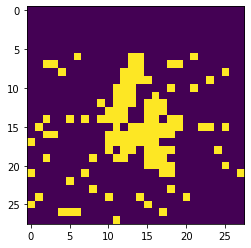

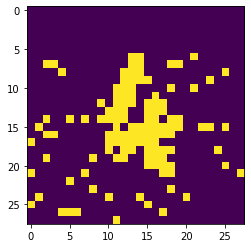

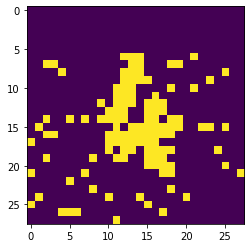

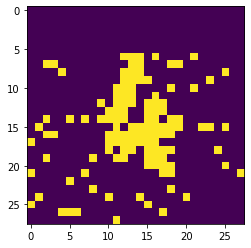

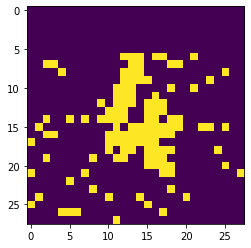

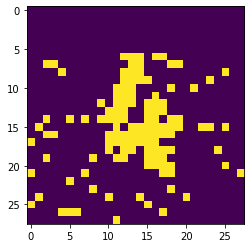

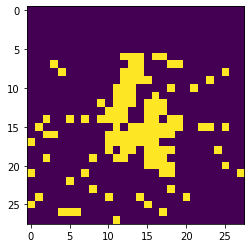

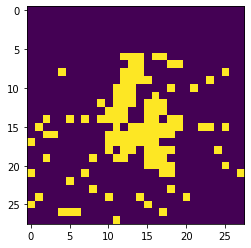

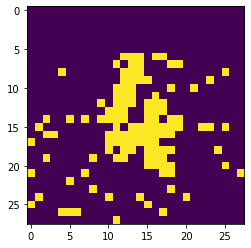

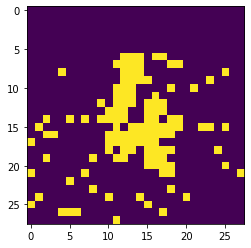

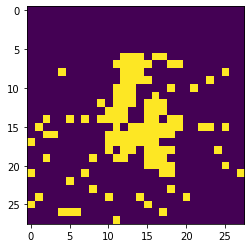

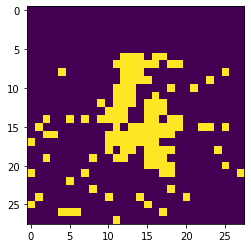

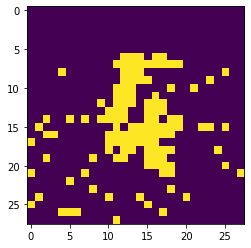

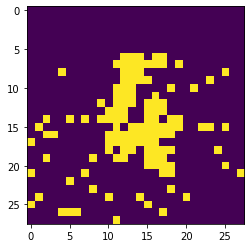

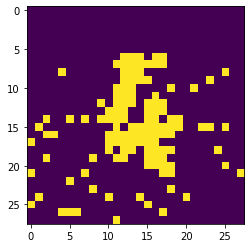

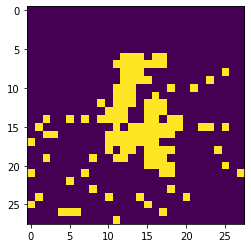

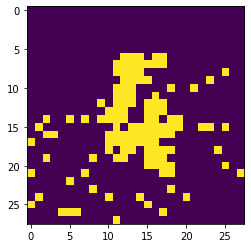

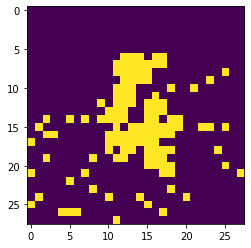

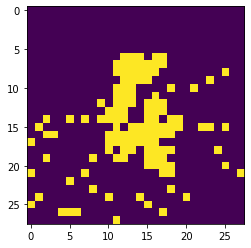

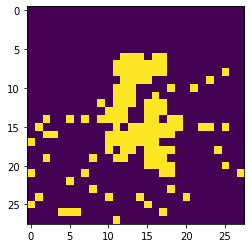

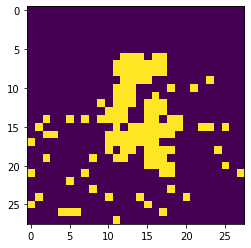

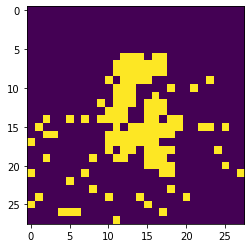

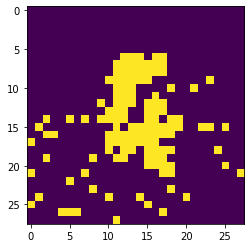

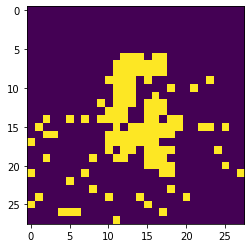

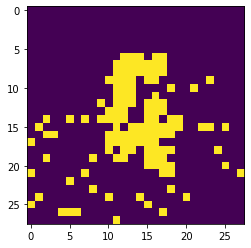

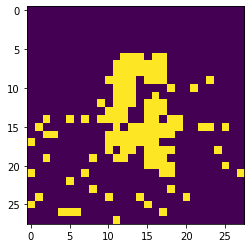

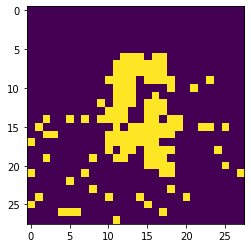

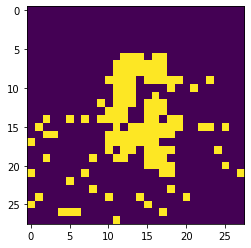

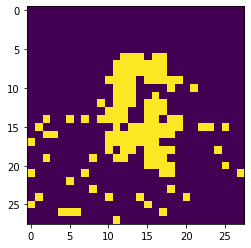

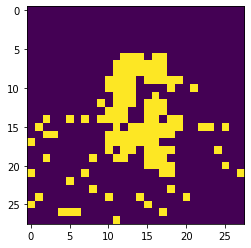

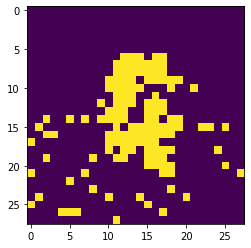

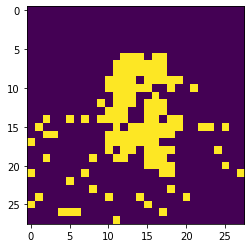

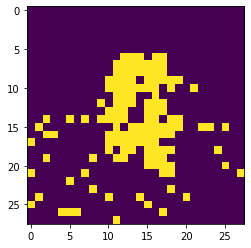

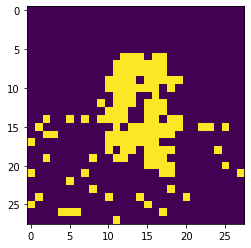

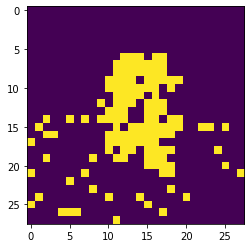

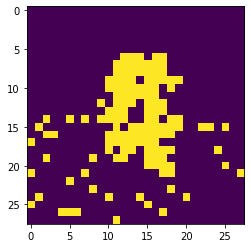

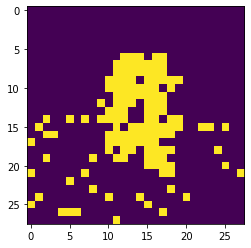

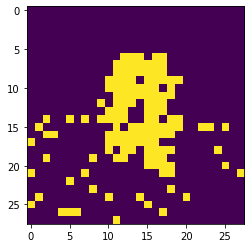

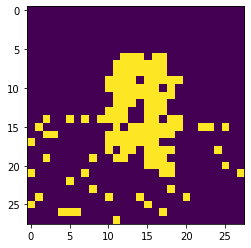

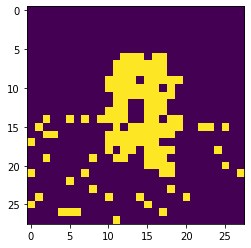

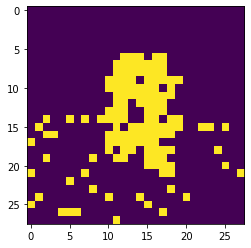

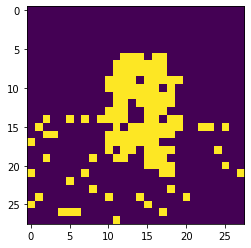

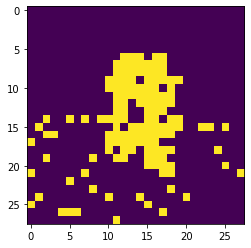

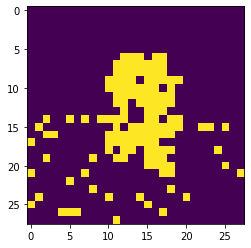

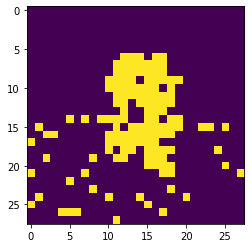

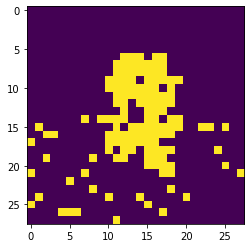

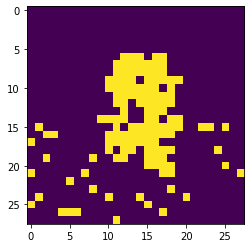

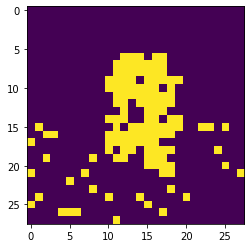

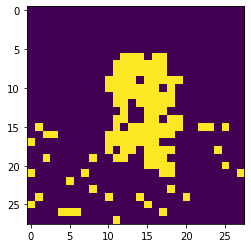

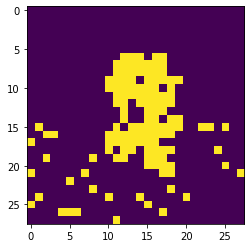

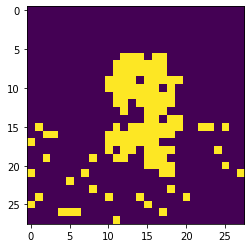

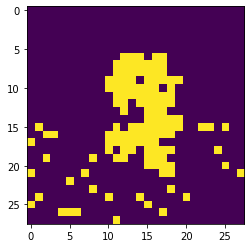

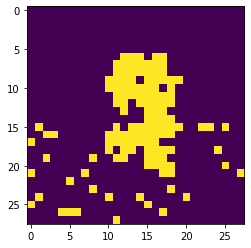

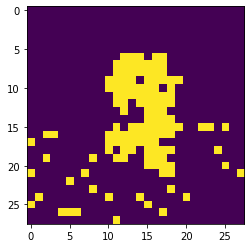

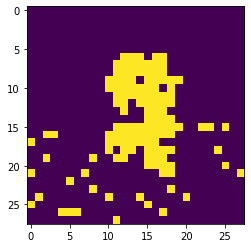

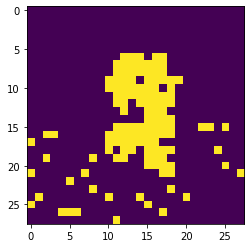

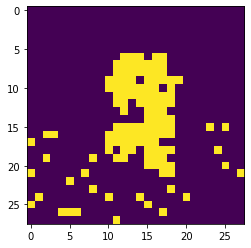

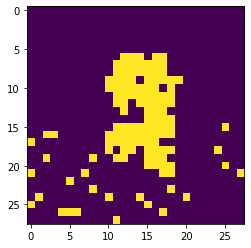

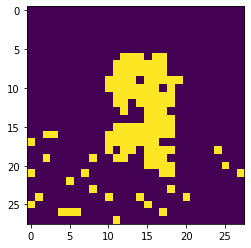

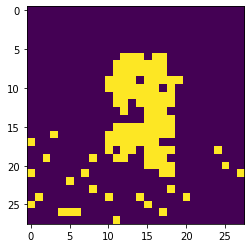

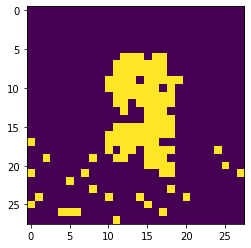

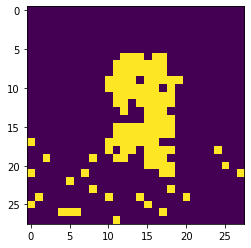

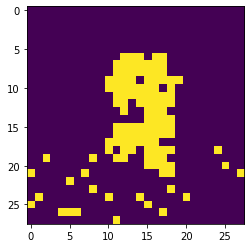

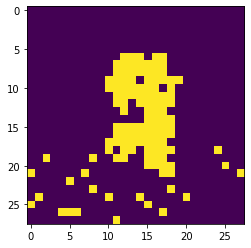

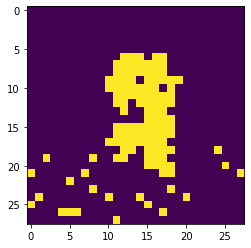

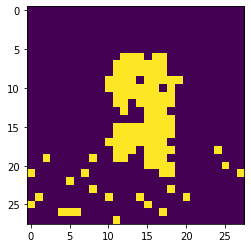

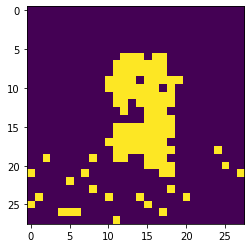

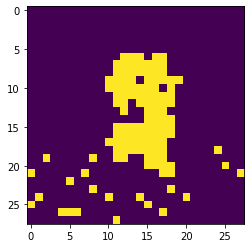

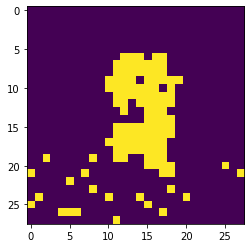

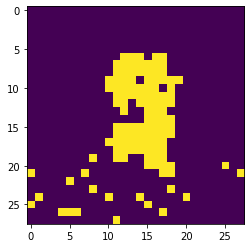

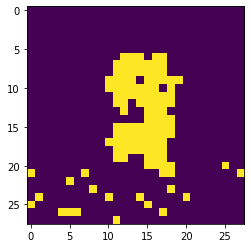

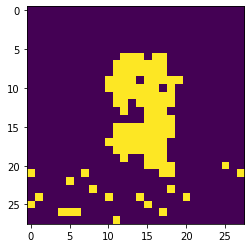

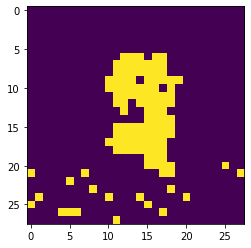

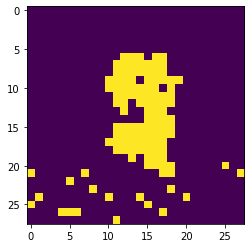

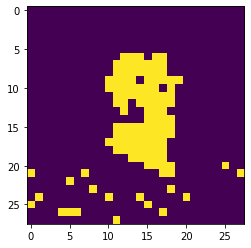

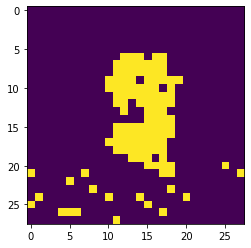

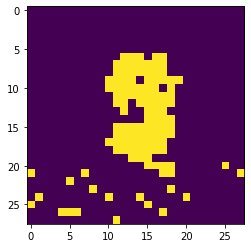

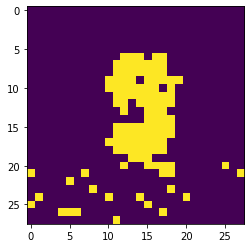

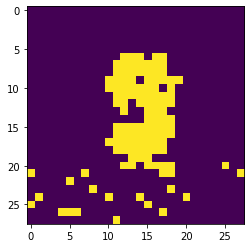

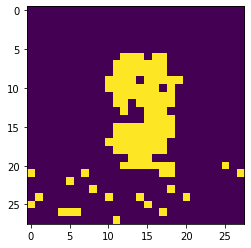

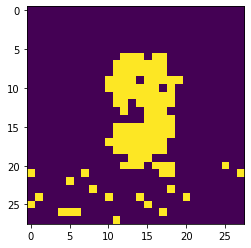

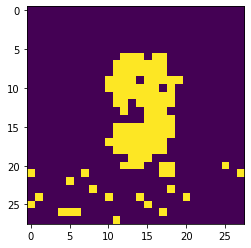

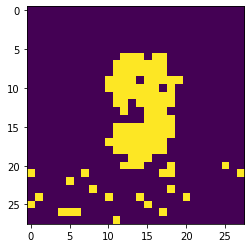

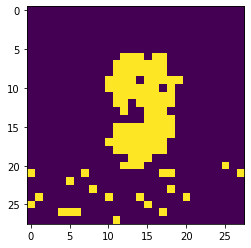

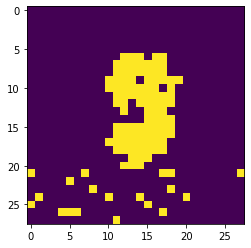

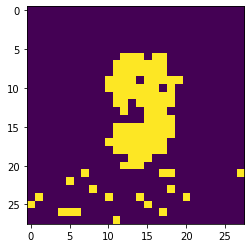

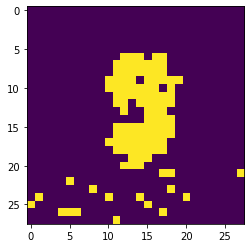

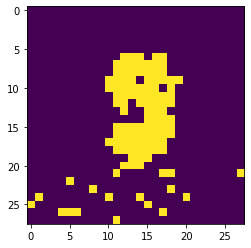

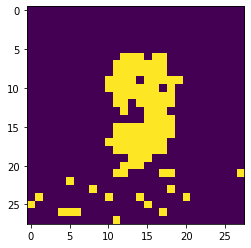

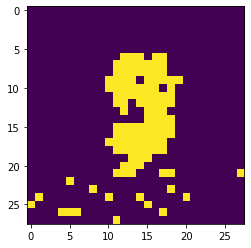

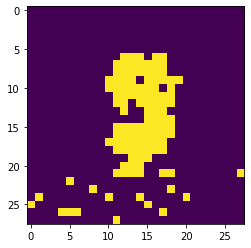

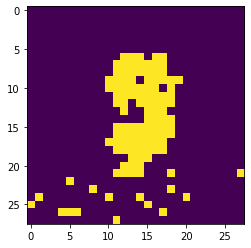

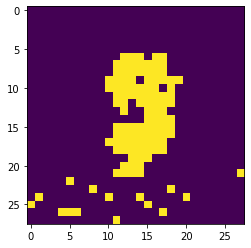

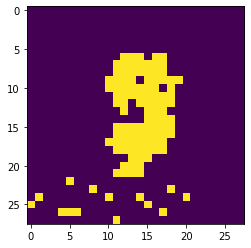

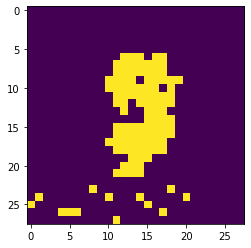

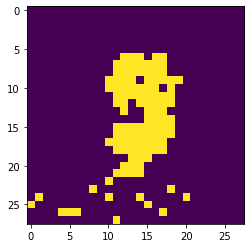

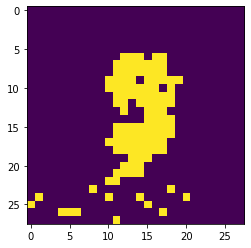

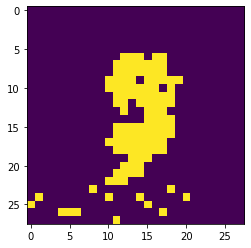

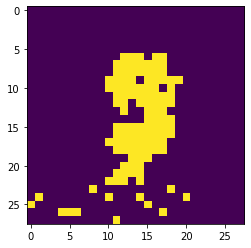

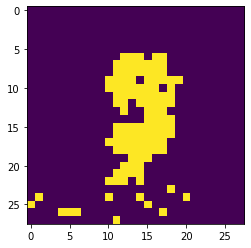

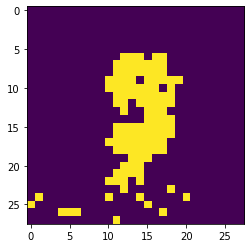

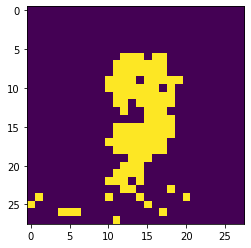

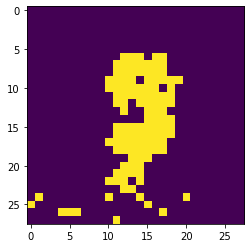

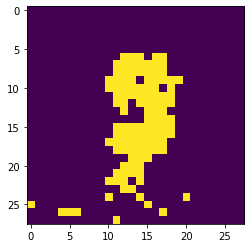

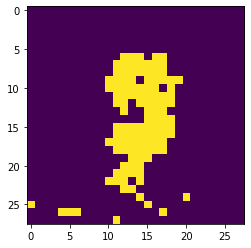

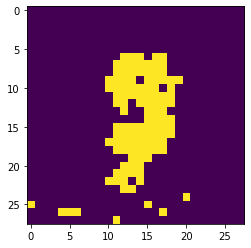

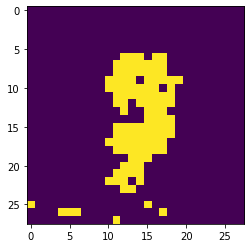

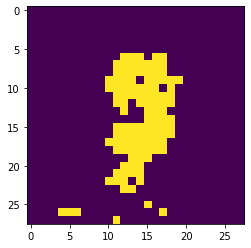

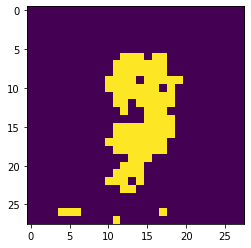

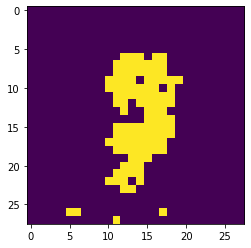

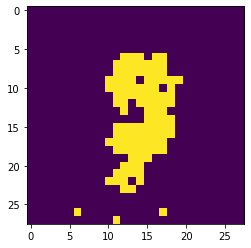

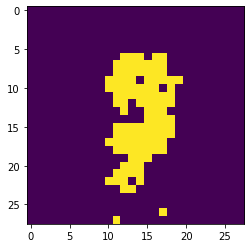

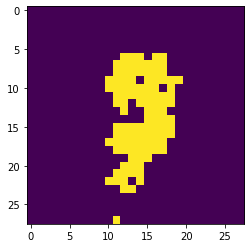

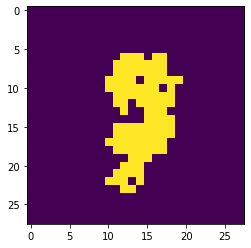

In [654]:
# Plot generated images from your Hopfield network as it updates after receiving
# an initial pattern that is a noisy version of an image that was stored

# number of time-steps to run the network for
numsteps = 784 # 784 == iterating through the entire state vector

# create an array for storing activity states over time
activity = np.zeros((numsteps,784))

# test using a noisy version of a random image
rand_image = patterns[random.randint(0,10),:]
activity[0,:] = image_noise(rand_image)
hnet.set_state(activity[0,:])

# incrimentally update one of its units
for t in range(numsteps-1):
    activity[t+1,:] = hnet.update(i=t)

# plots of the noised and original number
fig, axs = plt.subplots(2,2)
axs[0,0].imshow(activity[0,:].reshape((28,28)), cmap='gray')
axs[0,1].imshow(rand_image.reshape((28,28)), cmap='gray')
axs[0,0].axis("off")
axs[0,1].axis("off")
axs[1,1].axis("off")
axs[1,0].axis("off")
plt.show()

# plot network state only when a change is detected.
listy =[]
for c in range(numsteps):
    if c == 0:
        listy.append(activity[c,:].reshape((28,28)))
    elif not np.array_equal(activity[c,:], activity[c-1,:]):
            listy.append(activity[c,:].reshape((28,28)))
for i in range(len(listy)):
    plt.imshow(listy[i])
    plt.show()

# Given a combo of 2 images
overtime should settle to one of them

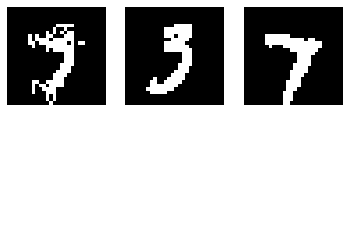

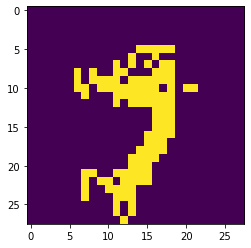

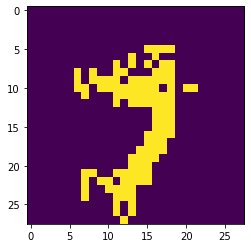

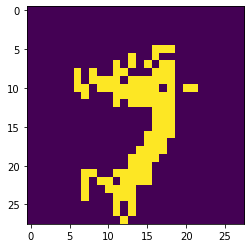

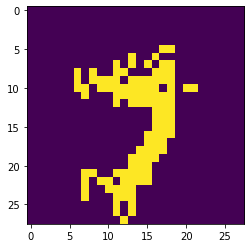

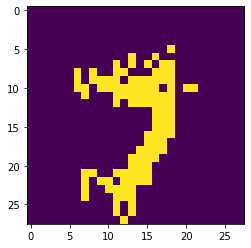

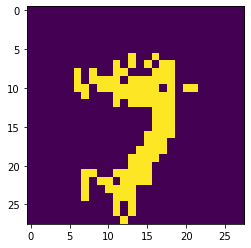

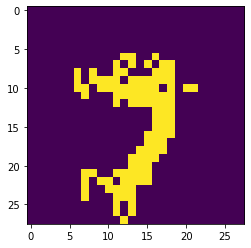

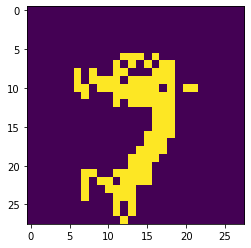

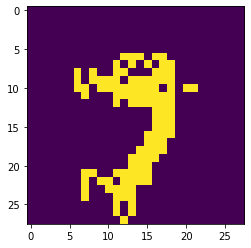

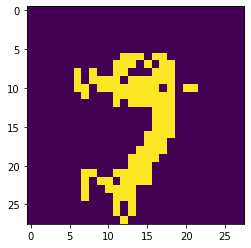

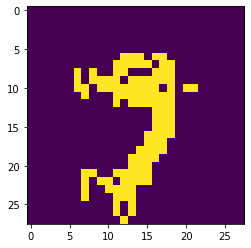

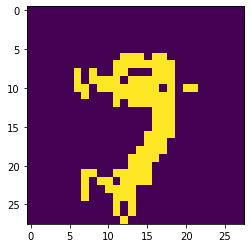

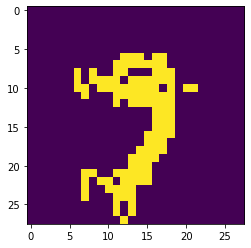

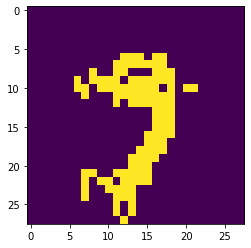

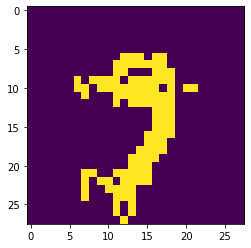

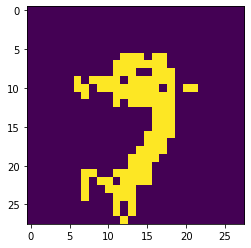

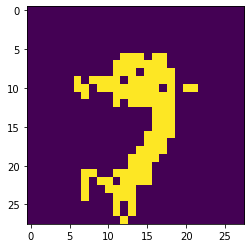

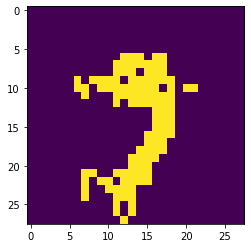

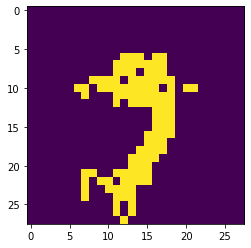

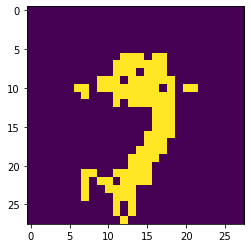

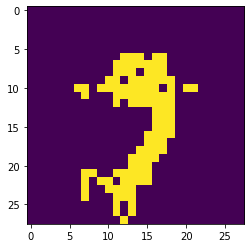

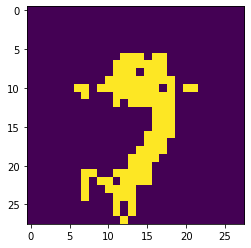

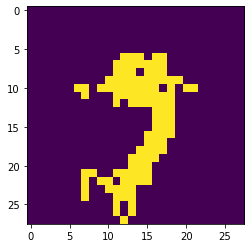

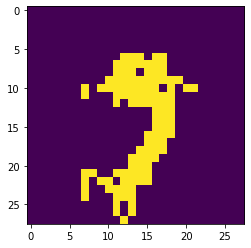

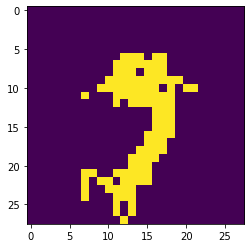

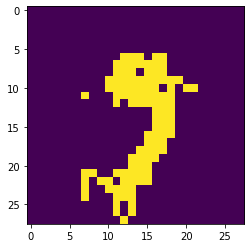

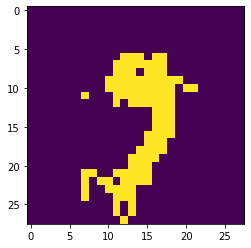

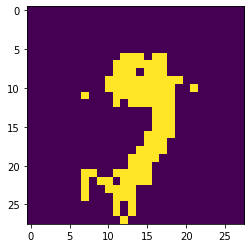

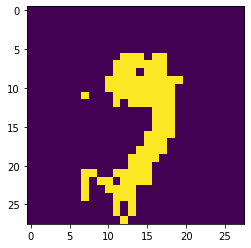

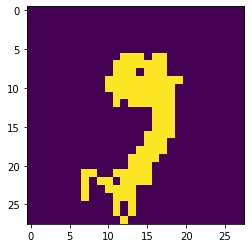

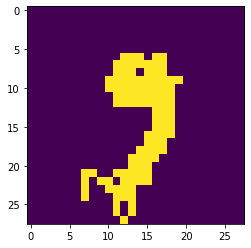

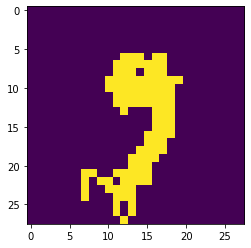

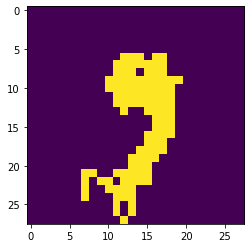

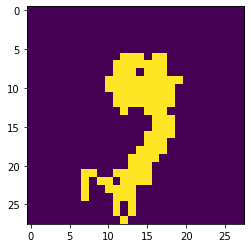

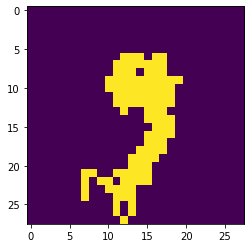

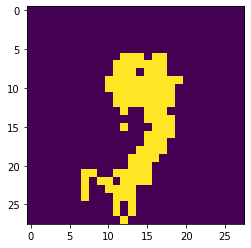

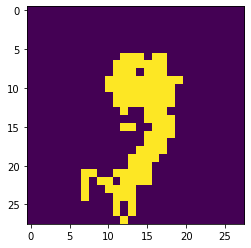

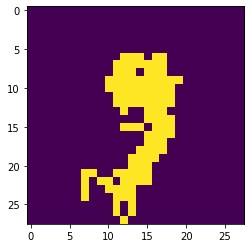

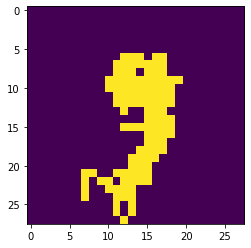

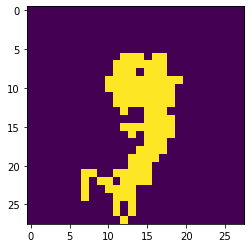

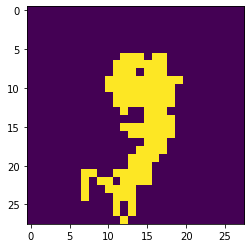

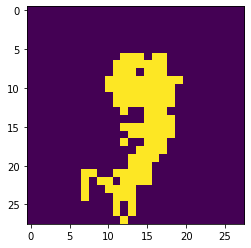

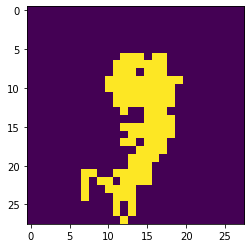

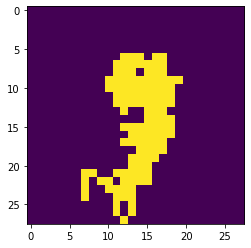

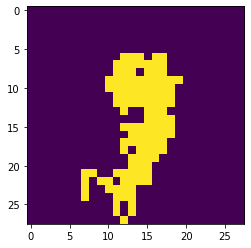

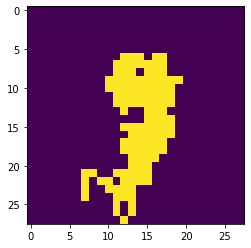

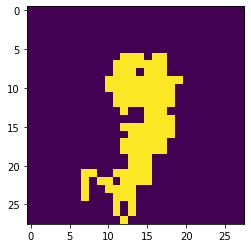

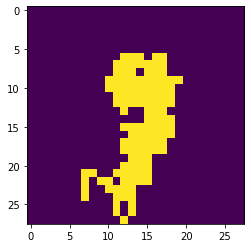

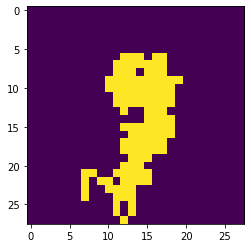

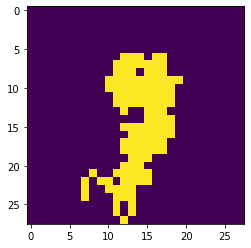

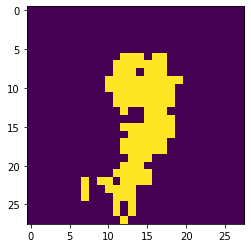

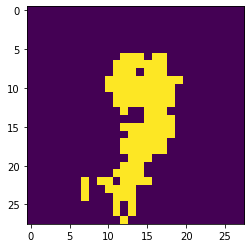

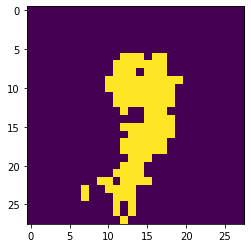

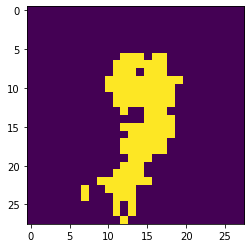

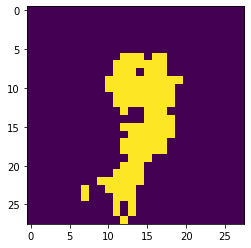

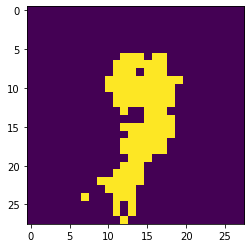

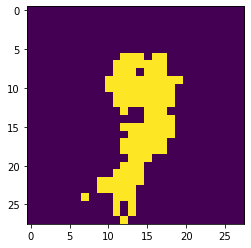

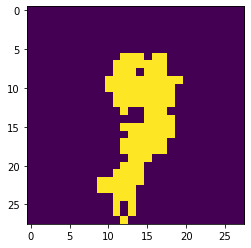

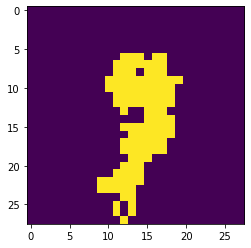

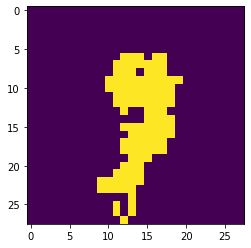

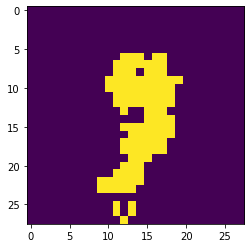

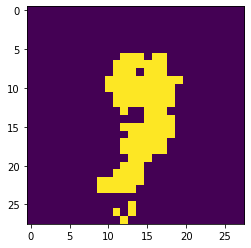

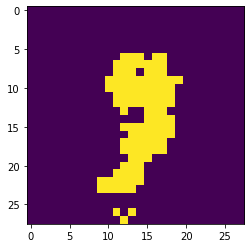

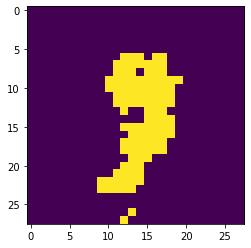

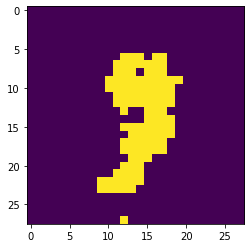

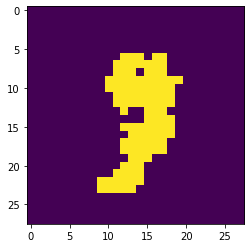

In [655]:
# Plot generated images from your Hopfield network as it updates after receiving
# an initial pattern that is a combination of two images that were stored

# number of time-steps to run the network for
numsteps = 784

# create an array for storing activity states over time
activity = np.zeros((numsteps,784))

# test using a combo of two random images
rand_image1 = patterns[random.randint(0,10),:]
rand_image2 = patterns[random.randint(0,10),:]
activity[0,:] = image_combo(rand_image1,rand_image2)
hnet.set_state(activity[0,:])

# incrimentally update one of its units
for t in range(numsteps-1):
    activity[t+1,:] = hnet.update(i=t)

# plots of the combined and original numbers
fig, axs = plt.subplots(2,3)
axs[0,0].imshow(activity[0,:].reshape((28,28)), cmap='gray')
axs[0,1].imshow(rand_image1.reshape((28,28)), cmap='gray')
axs[0,2].imshow(rand_image2.reshape((28,28)), cmap='gray')
axs[0,0].axis("off")
axs[0,1].axis("off")
axs[0,2].axis("off")
axs[1,2].axis("off")
axs[1,1].axis("off")
axs[1,0].axis("off")
plt.show()

# plot only when a change in the state is detected.
listy =[]
for c in range(numsteps):
    if c == 0:
        listy.append(activity[c,:].reshape((28,28)))
    elif not np.array_equal(activity[c,:], activity[c-1,:]):
            listy.append(activity[c,:].reshape((28,28)))
for i in range(len(listy)):
    plt.imshow(listy[i])
    plt.show()      

-------------
# DEBUG CELLS
------------
Not part of assignment questions, just cells I use for testing and debugging

#### Problem When the network is updating, it simply results in the following logic:
when updating, the network always converges to the average pattern of ALL the stored memory combined together.

2 patterns stored it does fine, but when theres 3 or more, the network fails and converges to an average of all

### Example of recoverying pattern successfully given two states stored

In [656]:
test = hopfield_network(784)

In [657]:
test.store_one(patterns[4])
test.store_one(patterns[7])
# test.store_one(patterns[0])

test.set_state(image_noise(patterns[4]))

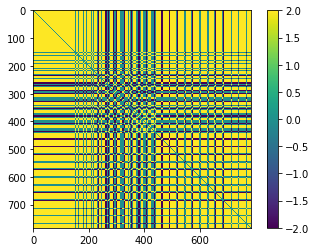

In [658]:
plt.imshow(test.W)
plt.colorbar()

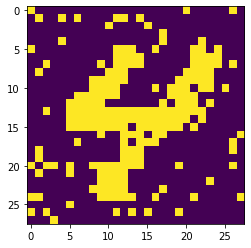

In [659]:
# the noised image before updating
plt.imshow(test.state.reshape((28,28)))

In [660]:
# update all nodes
for i in range(784):
    test.update(i)
    # test.energy() # was just to see that energy was monotone decreasing

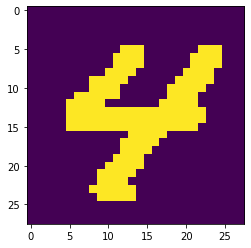

In [661]:
# network state after updating all pixels/nodes
plt.imshow(test.state.reshape((28,28)))
plt.show()

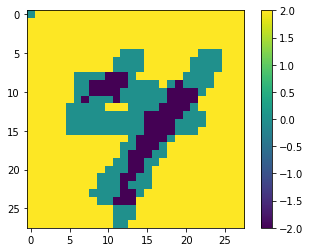

In [662]:
plt.imshow(test.W[0].reshape((28,28)))
plt.colorbar()

### Example of recovering to one of the combined images given two states stored

In [663]:
test2 = hopfield_network(784)

In [664]:
test2.store_one(patterns[4])
test2.store_one(patterns[7])

In [665]:
test2.set_state(image_combo(patterns[4],patterns[7]))

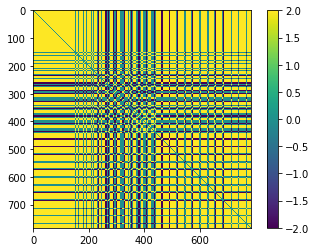

In [666]:
plt.imshow(test2.W)
plt.colorbar()

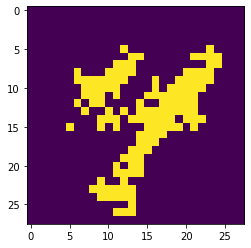

In [667]:
# the combined image before updating
plt.imshow(test2.state.reshape((28,28)))

In [668]:
# update all nodes
for i in range(784):
    test2.update(i)
    # test.energy() # was just to see that energy was monotone decreasing

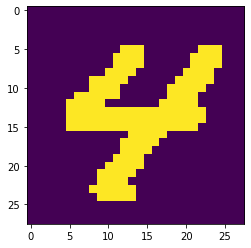

In [669]:
# network state after updating all pixels/nodes
plt.imshow(test2.state.reshape((28,28)))
plt.show()

### the weight matrix of the actual network

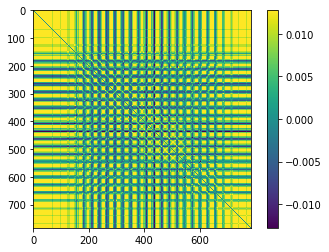

In [671]:
# the weight matrix of the actual network
plt.imshow(hnet.W)
plt.colorbar()

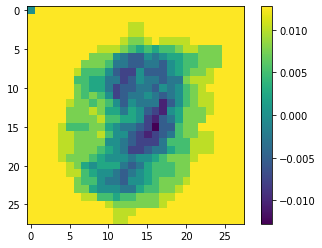

In [673]:
# weights of one of the rows, basically all patterns converge
# to this where they are negative.
plt.imshow(hnet.W[0].reshape((28,28)))
plt.colorbar()